In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import plot, iplot, init_notebook_mode
from sklearn.preprocessing import StandardScaler,LabelEncoder

from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/content/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
print("There are {:,} observations and {} columns in the data set.".format(df.shape[0], df.shape[1]))
print("There are {} missing values in the data.".format(df.isna().sum().sum()))

There are 1,338 observations and 7 columns in the data set.
There are 0 missing values in the data.


In [4]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [5]:
df.select_dtypes(include=['object']).describe()

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [6]:
cat=df.select_dtypes(include=['object']).columns.tolist()
for i in cat:
    obs=df[i].value_counts()
    avg_claim=df.groupby(i)["charges"].mean()
    display(pd.DataFrame({"Number of Policyholders":obs, "Average Claim Amount":avg_claim.map('${:,.2f}'.format)})\
            .sort_values('Number of Policyholders', ascending=False)\
            .style.set_caption("Variable: {}".format(i)))

,Number of Policyholders,Average Claim Amount
male,676,"$13,956.75"
female,662,"$12,569.58"


,Number of Policyholders,Average Claim Amount
no,1064,"$8,434.27"
yes,274,"$32,050.23"


,Number of Policyholders,Average Claim Amount
southeast,364,"$14,735.41"
northwest,325,"$12,417.58"
southwest,325,"$12,346.94"
northeast,324,"$13,406.38"


In [7]:
fig=px.histogram(df, x='charges', color='smoker', opacity=0.7, barmode='overlay',
                 histnorm='probability density', marginal='box', 
                 title="Distribution of Insurance Costs by Smoking Status",
                 color_discrete_sequence=['#B14B51','#B7A294']) 
fig.update_layout(font_color="#303030", xaxis_title='Claim Amount, $',
                  yaxis=dict(title='Probability Density', gridcolor='#EAEAEA', zerolinecolor='#EAEAEA'),
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""))
fig.update_xaxes(showgrid=False, zerolinecolor='#EAEAEA')
fig.show()

In [8]:
plot_df = df.copy()
plot_df["Age_Group"]=['18 to 29 years' if i<30 else '30 to 44 years' if (i>=30)&(i<45) else 
                      '45 to 59 years' if (i>=45)&(i<60) else '60 and over' for i in df['age']]
plot_df = plot_df.groupby(['Age_Group','smoker'])['charges'].mean()
plot_df = plot_df.rename('charges').reset_index().sort_values('smoker', ascending=True)
fig = px.bar(plot_df, x='Age_Group', y='charges', color='smoker', height=500, text='charges', 
             opacity=0.75, barmode='group', color_discrete_sequence=['#B7A294','#B14B51'],
             title="Average Insurance Costs by Age and Smoking Status")
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside', 
                  marker_line=dict(width=1, color='#303030'))
fig.update_layout(font_color="#303030",bargroupgap=0.05, bargap=0.3, 
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""),
                  xaxis=dict(title='Age',showgrid=False), 
                  yaxis=dict(title='Claim Amount, $', showgrid=False,zerolinecolor='#DBDBDB',
                             showline=True, linecolor='#DBDBDB', linewidth=2))
fig.show()

In [9]:
fig = px.scatter(df, x='bmi', y='charges', color='smoker', size='charges',
                 title="Insurance costs increase with Body Mass Index among Smokers",
                 color_discrete_sequence=['#B14B51','#B7A294'],height=600)
fig.update_layout(legend=dict(title='',orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
                  font_color="#303030", xaxis=dict(title='Body Mass Index (BMI)',showgrid=False), 
                  yaxis=dict(title='Claim Amount, $',showgrid=False, zerolinecolor='#E5E5EA',
                             showline=True, linecolor='#E5E5EA', linewidth=2))
fig.show()

In [10]:
plot_df = df.groupby(['region','sex','smoker'])['charges'].mean()
plot_df = plot_df.rename('charges').reset_index()
fig = px.bar(plot_df, x='region', y='charges', color='sex', height=800,
             title="Average Insurance Costs by Region and Smoking Status",
             color_discrete_map={'Female': '#BFC5DA','Male': '#5D6A92'}, 
             facet_row='smoker', text='charges', opacity=0.85, barmode='group')
fig.update_traces(texttemplate='$%{text:,.0f}', textposition='outside', 
                  marker_line=dict(width=1, color='#303030'))
fig.layout.yaxis2.update(matches=None)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(title="Region", row=1)
fig.update_yaxes(title="Claim Amount, $",  gridcolor='#E3E3E3', zeroline=True, zerolinewidth=2, 
                 showgrid=False, zerolinecolor='#E5E5EA',
                 showline=True, linecolor='#E5E5EA', linewidth=2)
fig.update_layout(font_color="#303030", paper_bgcolor="white", plot_bgcolor="white",
                  bargroupgap=0.05, bargap=0.2,
                  legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1, title=""))
fig.show()

In [11]:
# For keeping the original data
data = df

In [12]:
#le = LabelEncoder()

df[["sex","smoker","region"]] = df[["sex","smoker","region"]].apply(LabelEncoder().fit_transform)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520


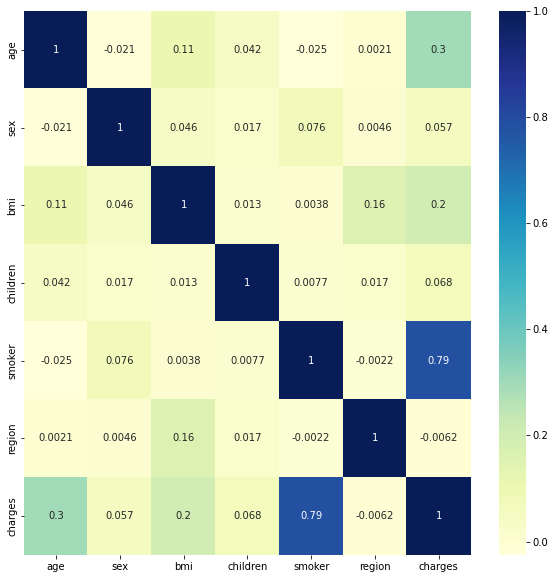

In [13]:
# plotting correlation heatmap
plt.figure(figsize=(10,10))
dataplot = sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
  
# displaying heatmap
plt.show()

In [15]:
s = StandardScaler()

X=df.drop(['charges', 'region'], axis=1)
y=df.charges
actuals=[]

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)
actuals.append(pd.Series(y_test, name='actuals').reset_index())

# Scale features
X_train = pd.DataFrame(data=s.fit_transform(X_train), columns=X.columns)
X_test = pd.DataFrame(data=s.transform(X_test), columns=X.columns)

# Tuning SVM
grid = {'kernel':['linear','rbf','poly','sigmoid'],
        'C': np.logspace(-3, 3, 10),
        'gamma':np.logspace(-3, 3, 10)}

In [19]:
svm = SVR()
svm_cv=RandomizedSearchCV(estimator=svm, param_distributions=grid, scoring='neg_mean_squared_error', 
                          n_iter=10, cv=3, random_state=21, n_jobs=-1)
preds=[]
rmses=[]
r2_scores=[]
adj_r2_scores=[]
svm_cv.fit(X_train, y_train)
print("Best SVM Parameters:\n",svm_cv.best_params_)
y_pred=svm_cv.predict(X_test)
preds.append(pd.Series(y_pred, name='preds').reset_index(drop=True))
rmse=np.sqrt(mean_squared_error(y_test, y_pred)).round(2)
r2=r2_score(y_test, y_pred)
adj_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
rmses.append(rmse)
r2_scores.append(r2)
adj_r2_scores.append(adj_r2)

print("\nTest Error (RMSE) = {:,}".format(rmse))
print("R-Squared = {:.2f}%, Adjusted R-Squared = {:.2f}%".format(r2*100, adj_r2*100))

Best SVM Parameters:
 {'kernel': 'poly', 'gamma': 10.0, 'C': 0.021544346900318832}

Test Error (RMSE) = 4,846.35
R-Squared = 84.27%, Adjusted R-Squared = 83.97%
